In [1]:
#Download the data
! curl -O https://raw.githubusercontent.com/AvantiShri/papers_analysisreplication/master/freedman_et_al_2023/their_data/TMS_TRIAL_DATA_2023JUL20.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3441k  100 3441k    0     0  3214k      0  0:00:01  0:00:01 --:--:-- 3215k


In [2]:
import pandas

tms_trial_data = pandas.read_csv("TMS_TRIAL_DATA_2023JUL20.csv")

In [3]:
tms_trial_data

,id,randomization,tmsgroup,condition,trial,reg
0,1,4,2,4,1,99
1,1,4,2,4,2,109
2,1,4,2,4,3,99
3,1,4,2,4,4,97
4,1,4,2,4,5,102
...,...,...,...,...,...,...
215995,108,4,2,1,496,98
215996,108,4,2,1,497,102
215997,108,4,2,1,498,101
215998,108,4,2,1,499,98


In [4]:
from collections import OrderedDict
import numpy as np

group_and_condition_to_trialdata = OrderedDict()

#gather the data for all of them
for group, group_easyname in [(1,"Rstim_Lfirst"),
                                              (2, "Rstim_Rfirst"),
                                              (3, "Lstim_Lfirst"),
                                              (4, "Lstim_Rfirst"),
                                              (5, "Sstim_Lfirst"),
                                              (6, "Sstim_Rfirst")]:
    group_and_condition_to_trialdata[group_easyname] = OrderedDict()
    for condition, condition_easyname in [(1, "expRight"),
                                          (2, "contRight"),
                                          (3, "expLeft"),
                                          (4, "contLeft")]:
        filtered_tms_data = tms_trial_data[(tms_trial_data["randomization"]==group)
                                           & (tms_trial_data["condition"]==condition)]
        trials_for_all_subjects = [] #gather the trials for all subjects into a list of lists
        subject_nums = set(filtered_tms_data["id"])
        for subject_num in sorted(subject_nums):
            data_for_subject = filtered_tms_data[filtered_tms_data["id"]==subject_num]
            #get the reg values, sorted in ascending order by trial number
            sorted_reg_values = np.array(data_for_subject["reg"])[np.argsort(data_for_subject["trial"])]
            trials_for_all_subjects.append(sorted_reg_values)
        trials_for_all_subjects = np.array(trials_for_all_subjects)
        group_and_condition_to_trialdata[group_easyname][condition_easyname] = trials_for_all_subjects

Plot the trend in the effect for first intention trials with contra-lateral stimulation

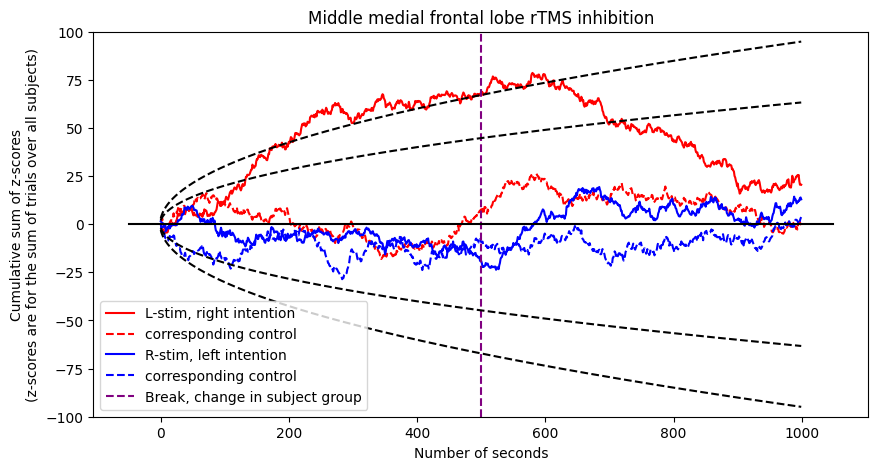

In [5]:
#plot to make sure
%matplotlib inline
from matplotlib import pyplot as plt

lines_to_plot = [
    ("Lstim_Rfirst", "Lstim_Lfirst", "expRight", 'red', '-', "L-stim, right intention"),
    ("Lstim_Rfirst", "Lstim_Lfirst", "contRight", 'red', '--', "corresponding control"),
    ("Rstim_Lfirst", "Rstim_Rfirst", "expLeft", 'blue', '-', "R-stim, left intention"),
    ("Rstim_Lfirst", "Rstim_Rfirst", "contLeft", 'blue', '--', "corresponding control"),
]

plt.figure(figsize=(10,5))
handles = []
handle_labels = []
for (groupname1, groupname2, conditionname, color, linestyle, label)  in lines_to_plot:
    data = np.concatenate([group_and_condition_to_trialdata[groupname1][conditionname],
                           group_and_condition_to_trialdata[groupname2][conditionname]], axis=1)
    handles.append(
         plt.plot(np.cumsum(np.sum(data-100, axis=0))/(np.sqrt(50)*np.sqrt(data.shape[0])),
                 color=color,
                 linestyle=linestyle)[0])
    handle_labels.append(label)
plt.title("Middle medial frontal lobe rTMS inhibition")
plt.ylabel("Cumulative sum of z-scores\n(z-scores are for the sum of trials over all subjects)")
plt.xlabel("Number of seconds")
handles.append(plt.plot([500,500],[-100,100], color="purple", linestyle="--")[0])
handle_labels.append("Break, change in subject group")
xlim = plt.xlim()
plt.plot(xlim, [0,0], color="black")
#2 sigma curve:
plt.plot(np.arange(data.shape[1]), 2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
#3 sigma curve:
plt.plot(np.arange(data.shape[1]), 3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.ylim(-100,100)
plt.legend(handles=handles, labels=handle_labels, loc=3)
plt.savefig('contra_stim_intention_trials.eps', format='eps')

Visually, after the break, it seems that the L-stim, right intention group of participants is having an effect in the opposite direction. To build our intuition for statistical significance, let's compute the z-score for just that trial group, keeping in mind that any resulting z-score (if formally reported) would need to be subject to multiple hypothesis correction over all possible groups, trials and directions, since we have no pre-defined reason to suspect that this trial for this group should move in the negative direction

In [6]:
import scipy

data = group_and_condition_to_trialdata["Lstim_Lfirst"]["expRight"]
z_score = np.sum(data-100)/np.sqrt(50*data.shape[0]*data.shape[1])
print("z score:", z_score)
print("percentile", scipy.stats.norm.cdf(z_score)) #this would not be significant after multiple hypothesis correction over all groups and directions, which would be appropriate since this is a post-hoc analysis

z score: -2.1197924426698003
percentile 0.017011776457947155


Check device variance

In [7]:
#verify that the device variance is near the theoretical expectation of 50
print(np.var(group_and_condition_to_trialdata["Lstim_Rfirst"]["contRight"]))
print(np.mean(group_and_condition_to_trialdata["Lstim_Rfirst"]["contRight"]))

49.05956365432099
100.02088888888889


In [21]:
#check for all the controls
all_controls = np.concatenate([
    group_and_condition_to_trialdata["Lstim_Rfirst"]["contRight"],
    group_and_condition_to_trialdata["Lstim_Rfirst"]["contLeft"],
    group_and_condition_to_trialdata["Lstim_Lfirst"]["contRight"],
    group_and_condition_to_trialdata["Lstim_Lfirst"]["contLeft"],
    group_and_condition_to_trialdata["Rstim_Rfirst"]["contRight"],
    group_and_condition_to_trialdata["Rstim_Rfirst"]["contLeft"],
    group_and_condition_to_trialdata["Rstim_Lfirst"]["contRight"],
    group_and_condition_to_trialdata["Rstim_Lfirst"]["contLeft"],
    group_and_condition_to_trialdata["Sstim_Rfirst"]["contRight"],
    group_and_condition_to_trialdata["Sstim_Rfirst"]["contLeft"],
    group_and_condition_to_trialdata["Sstim_Lfirst"]["contRight"],
    group_and_condition_to_trialdata["Sstim_Lfirst"]["contLeft"],
], axis=0)
print(all_controls.shape, all_controls.ravel().shape)
empirical_var = np.var(all_controls, ddof=1) #ddof=1 makes it an unbiased estimate of the variance i.e. sample variance
empirical_mean = np.mean(all_controls)
print(empirical_var, empirical_mean)

(216, 500) (108000,)
50.116456839278 100.01387037037037


Compute the standard error for the mean and variance

In [38]:
import scipy.stats

#standard error of mean
print("standard error of sample mean", scipy.stats.sem(all_controls.ravel())) #this is equivalent to np.std(all_controls.ravel(), ddof=1)/np.sqrt(108000)
#Standard error of variance - https://stats.stackexchange.com/questions/156518/what-is-the-standard-error-of-the-sample-standard-deviation
N = 108000
mu4 = np.mean(np.power(all_controls - np.mean(all_controls), 4))
print("standard error of sample variance", np.sqrt( ( mu4 - ((N-3)/(N-1))*(np.std(all_controls)**4) )/N ))
#As a sanity check, can compare to the standard error of the variance for a normal distribution
# (which the binomial distribution approximates by the central limit theorem)
print("standard error of sample variance applying CLT:", np.sqrt(2*(np.std(all_controls)**4)/(N-1)))
#As a further check, let's compare to the asymptotic standard error expected for a binomial distribution:
#Asymptotic standard error of variance for binomial distribution: https://stats.stackexchange.com/questions/105337/asymptotic-distribution-of-sample-variance-of-non-normal-sample/105338#105338
# Needs the fourth central moment of the binomial distribution: https://math.stackexchange.com/questions/142437/how-to-calculate-the-4th-central-moment-of-binomial-distribution
fourth_central_moment = (200*(0.5**5) + 3*200*199*(0.5**4))
print("asymptotic standard error of variance for binomial distribution:", np.sqrt((fourth_central_moment - (50**2))/N))



standard error of sample mean 0.021541617094135525
standard error of sample variance 0.21329371419703128
standard error of sample variance applying CLT: 0.21566589343924086
asymptotic standard error of variance for binomial distribution: 0.21449229460389585


Since there appears to be a decline effect, a monotonically decreasing weighting function is justified. We can compute a test statistic computes the p-value at each possible cutoff for the number of seconds to include, and compares that to the minimum p-value obtained over 1000 simulated trials (where the trial sum at each second is drawn from a binomial distribution). This effectively integrates over all possible monotonically decreasing weighting functions.

In [ ]:
true_data = np.concatenate([
    group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"],
    group_and_condition_to_trialdata["Lstim_Lfirst"]["expRight"]], axis=1)

NUM_SIM_TRIALS = 10000
sim_data = np.random.RandomState(1234).binomial(n=200, p=0.5,
                  size=(NUM_SIM_TRIALS, true_data.shape[0], true_data.shape[1]))

Maximum 'posthoc' z-score for true data: 3.8129334558134524 - attained at second number 273


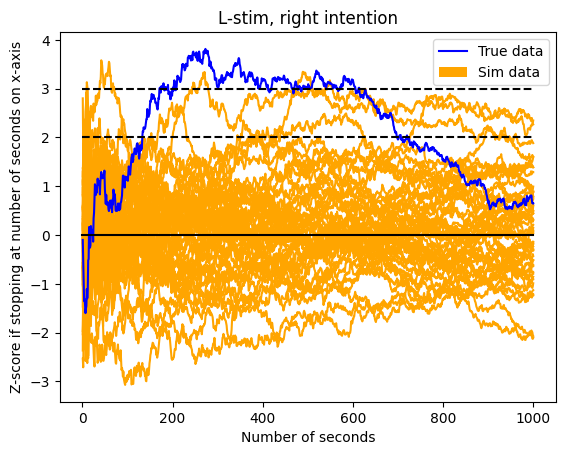

In [ ]:
from matplotlib.patches import Patch

def compute_cumsum_zscores(data, mean=100, var=50):#, do_plotting=False, plot_title=None, alpha=1.0, color="blue"):
  #Our goal in this function is to compute the statistical significance that would
  # be obtained if we had freedom to choose the number of seconds to include
  # (there is one 200-bit RNG sample per subject and second)
  #The data has shape (num_subjects, num_seconds)
  #first, we convert the individual 200-bit RNG samples to z-scores by subtracting the
  # mean (100) and dividing by the standard deviation (sqrt(50)) for a
  # binomial distribution with n=200 and p=0.5
  #If dealing with real data, we can also use the empirical mean and standard deviation
  # if these are more conservative (these are provided as function arguments)
  #then we take the sum over all subjects per second, and convert that to
  # a z-score for the second by dividing by sqrt of the number of subjects
  persecond_zscores = np.sum((data - mean)/np.sqrt(var), axis=0)/np.sqrt(data.shape[0])
  #Now we take the cumulative sum of per-second z-scores up to any given number
  # of seconds, and convert THAT to a z-score
  #We do this by dividing the cumulative sum up to the ith second by sqrt(i)
  #Note that np.arange(...) starts at 0, so we have to add 1
  cumsum_zscores = np.cumsum(persecond_zscores)/np.sqrt(np.arange(len(persecond_zscores))+1)

  return cumsum_zscores

#  if (do_plotting):
#    #add to plotting
#    handle = plt.plot(np.arange(len(persecond_zscores))+1, cumsum_zscores, alpha=alpha, color=color)
#    if (plot_title is not None):
#      plt.xlabel("Number of seconds")
#      plt.ylabel("Z-score if stopping at this number of seconds")
#      plt.title(plot_title)
#      plt.legend(handles=[handle[0], Patch(facecolor="orange", alpha=1)], labels=["True data", "Sim data"], loc=0)
#      plt.plot([0,data.shape[1]], [0,0], color="black")
#      plt.plot([0,data.shape[1]], [2,2], color="black", linestyle="--")
#      plt.plot([0,data.shape[1]], [3,3], color="black", linestyle="--")

  #We return the maximum cumsum z score over all seconds. This is the maximum "post hoc"
  # z-score we could have obtained for the trial if we had freedom to choose the number of
  # seconds to include
#  return np.max(cumsum_zscores), np.argmax(cumsum_zscores)+1, cumsum_zscores

sim_cumsum_zscores = np.array([compute_cumsum_zscores(data=x) for x in sim_data])
sim_max_zs = np.max(sim_cumsum_zscores, axis=1)

true_data_cumsum_zscores = compute_cumsum_zscores(data=true_data);#, mean=empirical_mean, var=empirical_var)
true_data_max_z = np.max(true_data_cumsum_zscores)
true_data_max_z_second = np.argmax(true_data_cumsum_zscores) + 1

#plotting
for i in range(0,sim_data.shape[0],200):
  plt.plot(np.arange(len(sim_cumsum_zscores[i]))+1, sim_cumsum_zscores[i], color="orange")
handle = plt.plot(np.arange(len(true_data_cumsum_zscores))+1, true_data_cumsum_zscores, color="blue")[0]
plt.legend(handles=[handle, Patch(facecolor="orange", alpha=1)], labels=["True data", "Sim data"], loc=0)
plt.xlabel("Number of seconds")
plt.ylabel("Z-score if stopping at number of seconds on x-axis")
plt.title("L-stim, right intention")
plt.plot([0,true_data.shape[1]], [0,0], color="black")
plt.plot([0,true_data.shape[1]], [2,2], color="black", linestyle="--")
plt.plot([0,true_data.shape[1]], [3,3], color="black", linestyle="--")

print("Maximum 'posthoc' z-score for true data:", true_data_max_z,
      "- attained at second number "+str(true_data_max_z_second))

plt.savefig('zscore_if_stopping_at_each_second.eps', format='eps')

Percentile of true relative to simualted:  0.9976
P value of true relative to simulated: 0.0024997500249975004


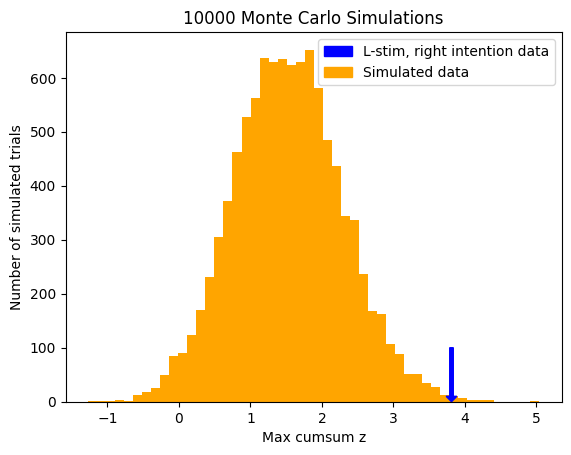

In [ ]:
plt.hist(sim_max_zs, bins=50, color="orange")
plt.arrow(true_data_max_z, 100, 0, -100, color="blue", head_length=10, length_includes_head=True, width=0.05)
plt.xlabel("Max cumsum z")
plt.ylabel("Number of simulated trials")
plt.legend(handles=[Patch(color='blue', label='L-stim, right intention data'),
                    Patch(color='orange', label='Simulated data')],
           loc="upper right")
plt.title(str(NUM_SIM_TRIALS)+" Monte Carlo Simulations")
plt.savefig('histogram_of_max_z_score.eps', format='eps')

true_rank = np.sum(true_data_max_z > sim_max_zs)
print("Percentile of true relative to simualted: ", true_rank/NUM_SIM_TRIALS)
#Note: the +1 correction in the numerator and denominator is based on https://pubmed.ncbi.nlm.nih.gov/21044043/
print("P value of true relative to simulated:", (1+NUM_SIM_TRIALS-true_rank)/(1+NUM_SIM_TRIALS) )

Plot the distribution of the effect for Lstim_Rfirst expRight for individual subjects

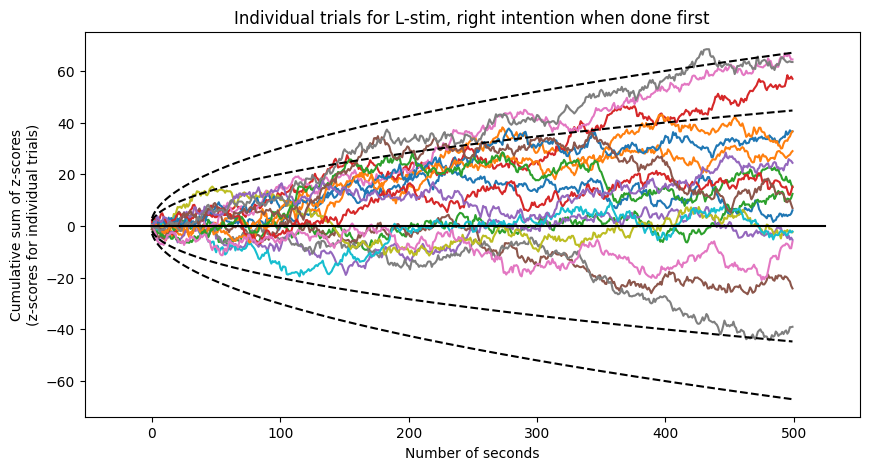

In [ ]:
data = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]

fig = plt.figure(figsize=(10,5))

for i in range(data.shape[0]):
    plt.plot(np.cumsum(data[i,:]-100)/(np.sqrt(50)))
xlim = plt.xlim()
plt.plot(xlim, [0,0], color="black")
#2 sigma curve:
plt.plot(np.arange(data.shape[1]), 2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
#3 sigma curve:
plt.plot(np.arange(data.shape[1]), 3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.title("Individual trials for L-stim, right intention when done first")
plt.ylabel("Cumulative sum of z-scores\n(z-scores for individual trials)")
plt.xlabel("Number of seconds")

plt.savefig('Lstim_Rfirst_expRight_individual.eps', format='eps')


Some other values quoted in the paper

In [ ]:
import scipy

print("95th percentile is sigma=",scipy.stats.norm.ppf(0.95))
print("2 sigma is a percentile of",scipy.stats.norm.cdf(2))
print("3 sigma is a percentile of",scipy.stats.norm.cdf(3))

95th percentile is sigma= 1.6448536269514722
2 sigma is a percentile of 0.9772498680518208
3 sigma is a percentile of 0.9986501019683699
